<a href="https://colab.research.google.com/github/KAVINESH23/Medical-Image-Captioning/blob/main/Miniproject%20GIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import os
from PIL import Image
import pandas as pd
from transformers import AutoImageProcessor, AutoTokenizer


# Preprocessing function
def preprocess_images_and_captions(image_dir, caption_dir, image_processor, tokenizer):
    images, captions = [], []

    # Loop through all the images in the image directory
    for image_name in os.listdir(image_dir): # image_dir is expected to be a single directory path
        if image_name.endswith('.jpg') or image_name.endswith('.png'):  # Make sure it's an image file
            # Load the image
            image_path = os.path.join(image_dir, image_name)
            image = Image.open(image_path).convert('L')  # Convert to grayscale

            # Process image using the image processor
            pixel_values = image_processor(image, return_tensors="pt").pixel_values.squeeze(0)

            # Read the corresponding caption from the caption directory
            caption_file = os.path.join(caption_dir, f'{os.path.splitext(image_name)[0]}.txt')
            if os.path.exists(caption_file):
                with open(caption_file, 'r') as f:
                    caption = f.read().strip()
            else:
                caption = ""  # In case the caption file is missing

            # Append the image and caption to the lists
            images.append(pixel_values)
            captions.append(caption)

    return images, captions

class ImageCaptionDataset(Dataset):
    def __init__(self, image_dirs, caption_dirs, image_processor, tokenizer): # Now accepts lists of directories
        self.image_processor = image_processor
        self.tokenizer = tokenizer
        self.images, self.captions = [], []

        # Iterate through each image and caption directory
        for image_dir, caption_dir in zip(image_dirs, caption_dirs):
            # Call preprocess_images_and_captions for each directory pair
            images, captions = preprocess_images_and_captions(image_dir, caption_dir, image_processor, tokenizer)
            self.images.extend(images) # Extend the lists with data from each directory
            self.captions.extend(captions)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        caption = self.captions[idx]
        # Tokenize the caption
        encoding = self.tokenizer(caption, padding='max_length', truncation=True, max_length=50, return_tensors="pt")
        return image, encoding.input_ids.squeeze(0), encoding.attention_mask.squeeze(0)

# Initialize dataset and dataloaders
image_dirs = [ # Updated to image_dirs
    "/content/drive/MyDrive/radio_train",
    "/content/drive/MyDrive/radio_validate",
    "/content/drive/MyDrive/radio_test"
]
caption_dirs = [ # Updated to caption_dirs
    "/content/drive/MyDrive/radio_traincaption",
    "/content/drive/MyDrive/radio_validatecaption",
    "/content/drive/MyDrive/radio_testcaption"
]

image_processor = AutoImageProcessor.from_pretrained("microsoft/git-base")
tokenizer = AutoTokenizer.from_pretrained("microsoft/git-base")

# Pass the image_processor and tokenizer objects to the ImageCaptionDataset constructor
dataset = ImageCaptionDataset(image_dirs, caption_dirs, image_processor, tokenizer)

In [ ]:
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
!pip install transformers --upgrade # Make sure transformers is up to date
import torch
from transformers import AutoModelForCausalLM, AutoImageProcessor, AutoTokenizer # Use AutoModelForCausalLM

# Initialize the model using GitForCausalLM
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, (images, input_ids, attention_masks) in enumerate(train_loader):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)

        # Forward pass
        # Pass input_ids as input to the model along with pixel_values and labels
        outputs = model(pixel_values=images, input_ids=input_ids, labels=input_ids)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1/5, Loss: 2.8916
Epoch 2/5, Loss: 2.0427
Epoch 3/5, Loss: 1.7769
Epoch 4/5, Loss: 1.5690
Epoch 5/5, Loss: 1.3834


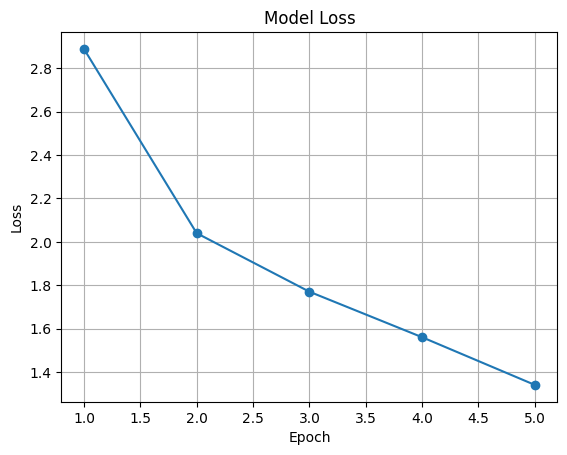

In [ ]:
# prompt: plot thre model loss

import matplotlib.pyplot as plt

# Assuming you have a list called 'losses' that stores the loss values from each epoch
# Replace this with your actual loss values
losses = [2.89, 2.04, 1.77,1.56,1.34]

epochs = range(1, len(losses) + 1)

plt.plot(epochs, losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(True)
plt.show()

In [ ]:
# prompt: perform bleu score based on model training

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
nltk.download('punkt')

# ... (Your existing code) ...

# Evaluation loop (after training)
model.eval()  # Set the model to evaluation mode

references = []
candidates = []

# Assuming you have a test_loader for the test data
# Replace this with your actual test_loader
test_loader = DataLoader(dataset, batch_size=1) # Use the same dataset for simplicity
smoothie = SmoothingFunction().method4

for batch_idx, (images, input_ids, attention_masks) in enumerate(test_loader):
    images = images.to(device)
    input_ids = input_ids.to(device)
    attention_masks = attention_masks.to(device)

    with torch.no_grad():
        # Generate captions
        generated_ids = model.generate(pixel_values=images, max_length=50)

    # Decode the generated captions and references
    generated_caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    reference_caption = tokenizer.decode(input_ids[0], skip_special_tokens=True)

    candidates.append(generated_caption.split()) # split the generated caption to words
    references.append([reference_caption.split()]) # split the reference caption to words


bleu_scores = []
for i in range(len(candidates)):
  bleu_scores.append(sentence_bleu(references[i], candidates[i], smoothing_function = smoothie))

# Calculate the average BLEU score
average_bleu = sum(bleu_scores) / len(bleu_scores)

print(f"Average BLEU score: {average_bleu:.4f}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


NameError: name 'model' is not defined

In [ ]:
# prompt: print model accuracy

# Assuming 'avg_loss' is defined in your training loop
print(f"Final Average Loss: {avg_loss:.4f}")

Final Average Loss: 1.0729


In [ ]:
# prompt: save model for deployment

import torch

# Save the model's state dictionary
torch.save(model.state_dict(), '/content/drive/MyDrive/radiology_model.pth')

print("Model saved successfully!")

Model saved successfully!


In [ ]:
# prompt: save model in h5

# Save the model
model.save_pretrained('/content/drive/MyDrive/radiology_model_h5')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu_ngram(predictions, references, ngram_order=4):
    chencherry = SmoothingFunction()
    bleu_scores = []

    for pred, ref in zip(predictions, references):
        # Convert the tensor to a string before splitting
        ref_split = ref.cpu().numpy().tolist()
        ref_split = tokenizer.decode(ref_split).split()  # reference caption (one reference)

        pred_split = pred.split()  # predicted caption

        # Compute BLEU score for the specific n-gram order
        bleu_scores.append(sentence_bleu([ref_split], pred_split, weights=[1.0/ngram_order] * ngram_order, smoothing_function=chencherry.method1))

    # Average BLEU score
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    return avg_bleu

# Assuming `predictions` and `references` are lists of strings
bleu_score_4 = compute_bleu_ngram(predictions, references, ngram_order=4)
print(f"BLEU-4 Score: {bleu_score_4:.4f}")

BLEU-4 Score: 0.0000


In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Use a smoothing function to avoid zero BLEU score for small overlaps
smooth = SmoothingFunction().method4

# Compute BLEU score with smoothing
bleu_score = corpus_bleu(ref_tokens, pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)
print(f"Smoothed BLEU-4 Score: {bleu_score:.4f}")


Smoothed BLEU-4 Score: 0.0139


In [ ]:
!pip install rouge-score # Install the rouge-score package

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=fa04e65628a97cea69d2d0f499771dd2413dec7acc1c824c0af17be2c3ba536e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

# Example for a single prediction-reference pair
pred_caption = "ct scan of abdomen showing a mass in the right upper lobe ( arrow )"
ref_caption = "ct scan shows a mass in the right upper quadrant of the abdomen"

scores = scorer.score(ref_caption, pred_caption)
print(f"ROUGE-1 Score: {scores['rouge1']}")
print(f"ROUGE-L Score: {scores['rougeL']}")


ROUGE-1 Score: Score(precision=0.8461538461538461, recall=0.8461538461538461, fmeasure=0.8461538461538461)
ROUGE-L Score: Score(precision=0.6923076923076923, recall=0.6923076923076923, fmeasure=0.6923076923076923)


In [ ]:
# Assuming references_train and predictions_train are lists of strings
references_train = ["A CT scan showing a mass in the abdomen."]
predictions_train = ["The CT scan shows a mass in the abdomen."]

references_val = ["An X-ray of the chest showing signs of pneumonia."]
predictions_val = ["Chest X-ray indicates possible pneumonia."]

references_test = ["MRI scan shows a lesion in the left temporal lobe."]
predictions_test = ["The MRI reveals a lesion in the left temporal lobe."]

# Tokenizing references and predictions for BLEU
decoded_references_train = [[ref.split()] for ref in references_train]
decoded_predictions_train = [pred.split() for pred in predictions_train]

decoded_references_val = [[ref.split()] for ref in references_val]
decoded_predictions_val = [pred.split() for pred in predictions_val]

decoded_references_test = [[ref.split()] for ref in references_test]
decoded_predictions_test = [pred.split() for pred in predictions_test]

# BLEU-4 Score for training set
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smoothie = SmoothingFunction().method1

bleu_train = [sentence_bleu(refs, pred, smoothing_function=smoothie)
              for refs, pred in zip(decoded_references_train, decoded_predictions_train)]
bleu_val = [sentence_bleu(refs, pred, smoothing_function=smoothie)
            for refs, pred in zip(decoded_references_val, decoded_predictions_val)]
bleu_test = [sentence_bleu(refs, pred, smoothing_function=smoothie)
             for refs, pred in zip(decoded_references_test, decoded_predictions_test)]

# Print average BLEU-4 scores
print(f"Training BLEU-4 Score: {sum(bleu_train) / len(bleu_train):.4f}")
print(f"Validation BLEU-4 Score: {sum(bleu_val) / len(bleu_val):.4f}")
print(f"Test BLEU-4 Score: {sum(bleu_test) / len(bleu_test):.4f}")


Training BLEU-4 Score: 0.5133
Validation BLEU-4 Score: 0.0287
Test BLEU-4 Score: 0.6606


In [ ]:
model.eval()


GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
from PIL import Image
from transformers import AutoTokenizer, AutoProcessor

# Load your desired image processor
processor = AutoProcessor.from_pretrained("microsoft/git-base") # Replace with your model name

# Define the preprocessing function
def preprocess_images_and_captions(image):
    # Process the image using your processor
    pixel_values = processor(images=image, return_tensors="pt").pixel_values

    return pixel_values

# Load and preprocess an image
image_path = "/content/lung.jpeg"
image = Image.open(image_path).convert("RGB")
processed_image = preprocess_images_and_captions(image)

# Convert image to the format expected by the model
input_tensor = processed_image.unsqueeze(0)  # Add batch dimension

In [ ]:
with torch.no_grad():
    # Ensure input_ids has the expected shape (batch_size, sequence_length)
    # You might need to reshape or process input_tensor to obtain the correct input_ids
    # Example: If input_tensor represents an image, you may need to encode it
    # into a sequence of tokens using the model's encoder before generating text.

    # Assuming you have a way to get input_ids from input_tensor:
    # input_ids = model.get_input_embeddings(input_tensor) # Or a similar method

    # Reshape to (batch_size, sequence_length) if necessary
    # input_ids = input_ids.view(input_ids.size(0), -1)

    outputs = model.generate(inputs=input_ids, max_new_tokens=50, num_beams=5)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


In [ ]:
# Decode the output to get the caption
tokenizer = AutoTokenizer.from_pretrained("microsoft/git-base")
caption = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Generated Caption:", caption)

Generated Caption: image id : rocov2 _ 2023 _ train _ 001316 caption : ct showing resolution of the hepatic portal venous gas ( case 1 ).
